In [1]:
import os
import urllib.request
import tarfile
from shutil import copyfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder

from torch.utils import model_zoo

from poutyne.framework import Model, ModelCheckpoint, BestModelRestore, CSVLogger
from poutyne import torch_to_numpy

In [2]:
def download_and_extract_dataset(path):
    tgz_filename = "images.tgz"
    urllib.request.urlretrieve("http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz", tgz_filename)
    os.makedirs(path, exist_ok=True)
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [3]:
def copy(source_path, filenames, dest_path):
    for filename in filenames:
        source = os.path.join(source_path, filename)
        dest = os.path.join(dest_path, filename)
        copyfile(source, dest)

def split_train_valid_test(dataset_path, train_path, valid_path, test_path, train_split=0.6, valid_split=0.2): # test_split=0.2
    np.random.seed(42)
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        train_class_path = os.path.join(train_path, classname)
        valid_class_path = os.path.join(valid_path, classname)
        test_class_path = os.path.join(test_path, classname)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        dataset_class_path = os.path.join(dataset_path, classname)
        filenames = sorted(filename for filename in os.listdir(dataset_class_path) if not filename.startswith('.'))
        np.random.shuffle(filenames)

        num_examples = len(filenames)
        train_last_idx = math.ceil(num_examples*train_split)
        valid_last_idx = train_last_idx + math.floor(num_examples*valid_split)
        train_filenames = filenames[0:train_last_idx]
        valid_filenames = filenames[train_last_idx:valid_last_idx]
        test_filenames = filenames[valid_last_idx:]
        copy(dataset_class_path, train_filenames, train_class_path)
        copy(dataset_class_path, valid_filenames, valid_class_path)
        copy(dataset_class_path, test_filenames, test_class_path)

In [4]:
# We do the split train/valid/test.

base_path = './CUB200'
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [5]:
download_and_extract_dataset(base_path)
split_train_valid_test(dataset_path, train_path, valid_path, test_path)

In [6]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [7]:
# Training hyperparameters

batch_size = 32
learning_rate = 0.1
n_epoch = 30
num_classes = 200

In [8]:
torch.manual_seed(42)

In [9]:
# Creation of the PyTorch's datasets for our problem.

norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [10]:
# Loading a pretrained ResNet-18 networks and replacing 
# the head with the number of neurons equal to our number 
# of classes.

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [11]:
# We freeze the network except for its head.

def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(resnet18)

In [12]:
# One nice feature of Pytoune is callbacks.

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint('last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),
    
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint('best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),
    
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger('log.tsv', separator='\t'),
]

In [13]:
# Finally, we start the training and output its final test 
# loss and accuracy.

# Optimizer and loss function
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

# Pytoune Model
model = Model(resnet18, optimizer, loss_function, metrics=['accuracy'])

# Send model on GPU
model.to(device)

# Train
model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch 1/30 27.98s Step 111/111: loss: 4.787067, acc: 6.101695, val_loss: 3.996494, val_acc: 9.646018
Epoch 1: val_acc improved from -inf to 9.64602, saving file to best_epoch_1.ckpt
Epoch 2/30 28.19s Step 111/111: loss: 3.087052, acc: 30.960452, val_loss: 3.078258, val_acc: 30.973451
Epoch 2: val_acc improved from 9.64602 to 30.97345, saving file to best_epoch_2.ckpt
Epoch 3/30 28.18s Step 111/111: loss: 2.187894, acc: 52.118644, val_loss: 2.815229, val_acc: 31.415929
Epoch 3: val_acc improved from 30.97345 to 31.41593, saving file to best_epoch_3.ckpt
Epoch 4/30 28.19s Step 111/111: loss: 1.680886, acc: 64.943503, val_loss: 2.534553, val_acc: 37.345133
Epoch 4: val_acc improved from 31.41593 to 37.34513, saving file to best_epoch_4.ckpt
Epoch 5/30 28.91s Step 111/111: loss: 1.341334, acc: 73.418079, val_loss: 2.304722, val_acc: 44.159292
Epoch 5: val_acc improved from 37.34513 to 44.15929, saving file to best_epoch_5.ckpt
Epoch 6/30 29.06s Step 111/111: loss: 1.139022, acc: 79.209040,

In [14]:
logs = pd.read_csv('log.tsv', sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch   lr      loss        acc  val_loss    val_acc
0       1  0.1  4.787067   6.101695  3.996494   9.646018
1       2  0.1  3.087052  30.960452  3.078258  30.973451
2       3  0.1  2.187894  52.118644  2.815229  31.415929
3       4  0.1  1.680886  64.943503  2.534553  37.345133
4       5  0.1  1.341334  73.418079  2.304722  44.159292
5       6  0.1  1.139022  79.209040  2.255917  43.982301
6       7  0.1  0.954160  83.305085  2.177992  45.398230
7       8  0.1  0.833283  86.355932  2.140329  47.787611
8       9  0.1  0.722319  89.661017  2.095337  46.548673
9      10  0.1  0.638380  91.779661  2.178889  43.893805
10     11  0.1  0.594623  92.881356  2.118647  46.106195
11     12  0.1  0.512462  95.000000  2.050763  48.230089
12     13  0.1  0.473167  95.988701  2.081674  48.849558
13     14  0.1  0.439125  96.440678  2.062657  47.787611
14     15  0.1  0.411999  96.779661  2.043332  49.646018
15     16  0.1  0.376445  97.796610  2.024585  50.176991
16     17  0.1  0.361033  98.05

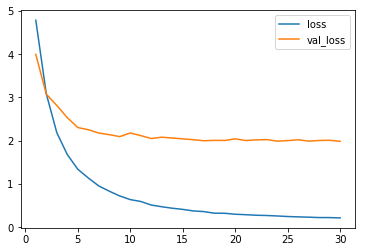

In [15]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

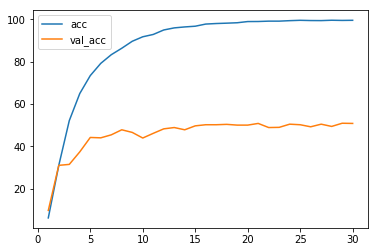

In [16]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

In [17]:
# Restore best model from checkpoint and test it.

resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(resnet18, None, nn.CrossEntropyLoss(), metrics=['accuracy'])

model.to(device)

model.load_weights('best_epoch_{epoch}.ckpt'.format(epoch=best_epoch))

test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Test:
	Loss: 2.092707781431348
	Accuracy: 50.33015409149147
